# Topic Modeling Lab

- In this lab, we'll learn about topic modeling. Topic modeling uses statistics to understand what text is about, that is, to find the topics in text.
- We'll use the online dating profile text that OKCupid made public as our example, but of course topic modeling can be used on any text.
- (Some of the code for this lab was adapted from [Aneesha Bakharia](https://medium.com/@aneesha/topic-modeling-with-scikit-learn-e80d33668730)'s example.)

# 0. Setup
### Step 1: Import the packages we'll use

In [1]:
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage
from scipy.interpolate import griddata
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.preprocessing import normalize
from bs4 import BeautifulSoup
import warnings
import matplotlib.pyplot as plt
%matplotlib inline

### Step 2: Read in our data 

#### Important note: 
Before loading this data, you **must** run the code from section `0. Setup` in Lab `1. What is in a dating profile?`. This code prepares the data we'll be using.

In [2]:
profiles = pd.read_csv('data/clean_profiles.tsv', sep='\t')
profiles.head(2)

,age_group,age,body,alcohol_use,drug_use,edu,race_ethnicity,height_group,industry,kids,...,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9
0,20,22,overweight,yes,no,HS,multiple,over_6,other,no,...,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...","books:<br />\nabsurdistan, the republic, of mi...",food.<br />\nwater.<br />\ncell phone.<br />\n...,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet!<br />\nyou...
1,30,35,average,yes,yes,unknown,White,under_6,other,no,...,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories.<br /...,NaN,NaN,i am very open and will share just about anyth...,NaN


### Step 3: Pick which section of the profiles you want to analyze.
#### Options:
- text - All of the text from a profile
- essay0 - My self summary
- essay1 - What I’m doing with my life
- essay2 - I’m really good at
- essay3 - The first thing people usually notice about me
- essay4 - Favorite books, movies, show, music, and food
- essay5 - The six things I could never do without
- essay6 - I spend a lot of time thinking about
- essay7 - On a typical Friday night I am
- essay8 - The most private thing I am willing to admit
- essay9 - You should message me if...

#### Replace `'essay0'` in the cell below with the essay you want to look at.

In [3]:
profile_section_to_use = 'essay8'

### Step 4: Clean up the text for that essay.
#### Helper function for cleaning up text
- removes HTML code, link artifacts
- converts to lowercase

In [4]:
# Some of the essays have just a link in the text. BeautifulSoup sees that and gets 
# the wrong idea. This line hides those warnings.
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

def clean(text):
    if pd.isnull(text):
        t = np.nan
    else:
        t = BeautifulSoup(text, 'lxml').get_text()
        t = t.lower()

        bad_words = ['http', 'www', '\nnan']

        for b in bad_words:
            t = t.replace(b, '')
    if t == '':
        t = np.nan
    
    return t

#### Clean and select the text.

In [5]:
print('Cleaning up profile text for', profile_section_to_use, '...')
profiles['clean'] = profiles[profile_section_to_use].apply(clean)

print('We started with', profiles.shape[0], 'profiles.')
print("Dropping profiles that didn't write anything for the essay we chose...")
profiles.dropna(axis=0, subset=['clean'], inplace=True)

print('We have', profiles.shape[0], 'profiles left.')

Cleaning up profile text for essay8 ...
We started with 58785 profiles.
Dropping profiles that didn't write anything for the essay we chose...
We have 39881 profiles left.


# 1. Topic Modeling
#### Some parameters: change these to get different numbers of topics or words per topic

In [6]:
#how many topics we want our model to find
ntopics = 20

#how many top words we want to display for each topic
nshow = 10

#what we will use as our documents, here the cleaned up text of each profile
documents = profiles['clean'].values

## 1.1 LDA
- LDA stands for Latent Dirichlet Allocation. The statistical math behind it is complicated, but its goals are simple. 
    - find groups of words that often show up together and call those groups topics. 
    - find topics that can be used to tell documents apart, i.e. topics that are in some documents but not others.
- LDA is the most popular method for topic modeling.
- We must tell LDA how many topics we want it to look for (we did this above with the `ntopics` variable.
- [Learn more](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) about LDA

### Step 1: Convert text to numbers the computer understands
- LDA takes "count vectors" as input, that is, a count of how many times each word shows up in each document. 
    - Here we tell it to only use the 1,000 most popular words, ignoring stop words like "a" and "of".
    - We use the abbreviation `tf` for these because they represent "text frequency," i.e., how often each word shows up in text.

In [7]:
tf_vectorizer = CountVectorizer(max_features=1000, stop_words='english')

print("Vectorizing text by word counts...")
tf_text = tf_vectorizer.fit_transform(documents)

tmp = tf_text.get_shape()
print("Our transformed text has", tmp[0], "rows and", tmp[1], "columns.")

Vectorizing text by word counts...
Our transformed text has 39881 rows and 1000 columns.


#### See what words are being counted

In [8]:
tf_feature_names = tf_vectorizer.get_feature_names()

print("The first few words (alphabetically) are:\n", tf_feature_names[:20])

The first few words (alphabetically) are:
 ['10', '100', '11', '12', '14', '15', '16', '18', '20', '30', '40', 'able', 'absolutely', 'accent', 'accident', 'accidentally', 'account', 'act', 'actually', 'add']


#### See an example of how a profile's text is encoded
- Change the value of `n` and re-run the code to see different profiles.
- Note that only some of the words are counted. This is because we set `max_features=1000` in the vectorizor function, so it is only counting the 1,000 most common words and ignoring the rest. 
    - You can change that number to be bigger or smaller and see what happens.
    - We found in Lab 1 that 1,000 is a good choice for this data because words less popular than that show up in less than 1% of all profiles.

In [9]:
n = 6

def show_vector(x):
    rows,cols = x.nonzero()
    for row,col in zip(rows,cols):
        print(tf_feature_names[col], x[row,col])

print('Profile text:\n', documents[n])
print('\nTF (count) vector:')
show_vector(tf_text[n])

Profile text:
 and say hi.

TF (count) vector:
say 1


### Step 2: Build a topic model using LDA

- LDA can be a little slow. We'll use a faster method later on.
- Set `n_jobs=` to the number of processors you want to use to compute LDA. If you set it to `-1`, it will use all available processors. 

In [10]:
model = LatentDirichletAllocation(n_components=ntopics, max_iter=10, 
                                  learning_method='online', n_jobs=-1)

print('Performing LDA on vectors...')
lda = model.fit(tf_text)

print('Done!')

Performing LDA on vectors...
Done!


#### Some helper functions 
Don't worry about how these work right now. We'll use them to make our analysis easier later on.

In [11]:
def describe_topic(topic, feature_names, n_words=10):
    words = []
    # sort the words in the topic by importance
    topic = topic.argsort() 
    # select the n_words most important words
    topic = topic[:-n_words - 1:-1]
    # for each important word, get it's name (i.e. the word) from our list of names
    for i in topic:
        words.append(feature_names[i])
    # print the topic number and its most important words, separated by spaces
    return " ".join(words)

def display_topics(components, feature_names, n_words=10):
    # loop through each topic (component) in the model; show its top words
    for topic_idx, topic in enumerate(components):
        print("Topic {}:".format(topic_idx), 
              describe_topic(topic, feature_names, n_words))
    return

def sort_topics(components):
    n = components.shape[0]
    # run hierarchical clustering to find related groups of topics
    l = linkage(components, "ward")
    # calculate the id of the final cluster
    last_id = 2 * n - 2
    # start with the final cluster and break it into smaller clusters
    order = [last_id]
    for i, row in reversed(list(enumerate(l))):
        # find the current cluster in the list and break it into two smaller clusters
        cluster_id = n + i
        index = order.index(cluster_id)
        order = order[:index] + [row[0], row[1]] + order[(index+1):]
    # sort topics by the order calcuated above and return a copy
    components = [x[1] for x in sorted(zip(order, components))]
    return np.array(components)

def get_similarity(a, b=None):
    n = a.shape[0]
    # normalize the topics so that their dot product is 1
    a = normalize(a)
    # if only one set of topics is given, compare it to itself
    if b is None:
        b = a
    else:
        b = normalize(b)
    # create a 2-D array to store the results of the similarity calcluation
    topic_similarity = np.zeros((n, n))
    # loop through each topic in both a and b
    for topic_idx, row in enumerate(a):
        for topic_jdx, col in enumerate(b):
            # calculate the similarity using a dot product
            topic_similarity[topic_idx, topic_jdx] = np.inner(row, col)
    return topic_similarity

def describe_intersection(components, a, b, feature_names, n_words=10):
    # normalize
    topic_a = components[a,:] / components[a,:].sum()
    topic_b = components[b,:] / components[b,:].sum()
    # multiply components of a and b to highlight words common in both
    x = topic_a * topic_b
    print("Words in {} and {}:".format(a, b), 
          describe_topic(x, feature_names, n_words))

def describe_difference(components, a, b, feature_names, n_words=10):
    # normalize
    topic_a = components[a,:] / components[a,:].sum()
    topic_b = components[b,:] / components[b,:].sum()
    # multiply components of a with complement of components in b
    x = topic_a * (1 - topic_b)
    print("Words in {} but not in {}:".format(a, b), 
          describe_topic(x, feature_names, n_words))

def plot_topics(components):
    # sort topics into similar groups
    components = sort_topics(components)
    # calculate similarity between topics
    topic_similarity = get_similarity(components)
    # create a figure and plot the similarites
    plt.figure()
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(np.log10(topic_similarity), cmap='Blues')
    # move the ticks to the top and maker sure each topic is labeled
    ax.xaxis.tick_top()
    plt.xticks(range(20))
    plt.yticks(range(20))
    # plot a colorbar legend
    plt.colorbar()
    
def plot_confusion(x, y):
    # normalize all topics so their inner product is 1
    a = normalize(y)
    b = normalize(x)
    # match topics in b with their most similar topic in a
    sorted_b = []
    order_b = []
    idx_b = np.arange(x.shape[0])
    for ta in a:
        # of the b topics not yet assigned, find the one that best matches
        best_b = max([(np.inner(ta, b[i,:]), i) for i in range(b.shape[0])])[1]
        # move the b topic into the sorted list
        sorted_b.append(b[best_b,:])
        order_b.append(idx_b[best_b])
        b = np.delete(b, best_b, axis=0)
        idx_b = np.delete(idx_b, best_b, axis=0)
    # replace b topics with the sorted version
    b = np.array(sorted_b)
    # find similarity
    topic_similarity = get_similarity(a, b)
    # create a figure and plot the similarity valuse
    plt.figure()
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(np.log10(topic_similarity), cmap='Blues')
    # move the ticks to the top and reorder the x ticks because b was sorted
    ax.xaxis.tick_top()
    plt.xticks(range(20), order_b)
    plt.yticks(range(20))
    # show a colorbar legend
    plt.colorbar()

### Step 3: Show our topics with the top words in each

In [12]:
lda_topics = sort_topics(lda.components_)
display_topics(lda_topics, tf_feature_names, n_words=nshow)

Topic 0: really don going won people questions kid mean thought secrets
Topic 1: years bad school believe high come told isn secret tv
Topic 2: good enjoy night didn yes romantic haha awesome guys learned
Topic 3: day music like eat real away love doing bed wait
Topic 4: ve life used man girl great live relationship recently like
Topic 5: little right oh fun movies ve afraid like movie doesn
Topic 6: love time people way friends best need hard play think
Topic 7: admit lol question sure work bit trying sorry hmmm songs
Topic 8: hate hair look idea super fear dog food website words
Topic 9: person want long talk did time mind funny totally type
Topic 10: just ask guess answer internet makes sing want wear things
Topic 11: know don private open book like wouldn care sense honest
Topic 12: like thing think profile dating willing admit private online site
Topic 13: lot probably maybe share seriously stuff went message means lost
Topic 14: things let big ok sex public getting wish self poin

### Step 4: Compare topics to each other

We can compare topics visually by plotting the similarity of each topic to each other topic.
Groups of similar topics are placed closer together.
- Why are the diagonal cells the darkest?
- What do dark or light bands represent?
- Do you see dark regions made of several cells? If so, what do they represent?

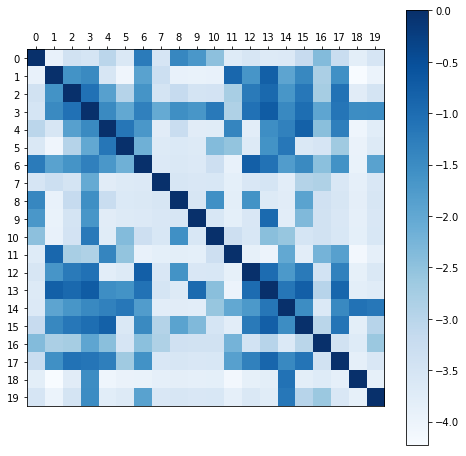

In [13]:
plot_topics(lda_topics)

#### Examine the words that make two topics similar or different
We can also compare two topics to each other by looking at words that are common in both,
or words that are common in one but not the other.
Try changing `topic_a` and `topic_b` to different topic numbers.

In [14]:
topic_a = 9
topic_b = 15

describe_intersection(lda_topics, topic_a, topic_b, tf_feature_names, n_words=nshow)
describe_difference(lda_topics, topic_a, topic_b, tf_feature_names, n_words=nshow)
describe_difference(lda_topics, topic_b, topic_a, tf_feature_names, n_words=nshow)

Words in 9 and 15: ll ask tell person want pretty meet long talk did
Words in 9 but not in 15: person want long talk did time mind funny totally type
Words in 15 but not in 9: ll ask tell pretty meet definitely remember cats damn loud


### Step 5: Interpret these topics
- This part is for you to do: code can't do it for you.
- Look at the list of important words for each topic, and think about these questions.
    - What do the words have in common?
    - What could someone write that would use most of those words?
    - What does this topic seem to be about?
- Try to come up with a short, catchy name for each topic.
    - For example, if the words were "san francisco city moved living born years raised lived live", you might call it "places lived" because the topic seems to be about where people currently live (San Francisco) and where they were born / raised / moved from. 
- Try other numbers of topics.
    - If the topics seem repetitive, you might want to try looking for fewer topics.
    - If the topics seem confusing or vague, you might want to try looking for more topics (so that they can be more specific).

## 1.2 NMF
- NMF stands for Non-Negative Matrix Factorization. Just like you may have found factors in algebra class, this finds factors for the matrix of numbers representing word frequency in text. For example:
    - $ 10 $ can be factored as $ 2 * 5 $
    - $ x^2+3x+2 $ can be factored as $ (x+2)(x+1)$
- It turns out that finding factors for text is a really good way of finding topics. This makes sense intuitively: factors are simple things we can combine to get the more complicated output, and topics are simple things people combine to write profiles.
- [Learn more](https://en.wikipedia.org/wiki/Non-Negative_matrix_factorization#Text_mining) about NMF.


### Step 1: Convert text to numbers the computer understands
- NMF takes "tf-idf vectors" as input. Tf-idf stands for "text frequency - inverse document frequency." 
    - Text frequency is the same as the count vectors above: how often does each word appear in the text?
    - Inverse document frequency means we divide ("inverse") by the number of documents the word is in. (If everyone uses the word, it isn't very helpful for figuring out what makes people different. So this measurement looks for words that are used a lot in some documents, and not at all in others.)
    - Here we tell it to only use the 1,000 most popular words, ignoring stop words

In [15]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')

print("Vectorizing text by TF-IDF...")
tfidf_text = tfidf_vectorizer.fit_transform(documents)

tmp = tfidf_text.get_shape()
print("Our transformed text has", tmp[0], "rows and", tmp[1], "columns.")

Vectorizing text by TF-IDF...
Our transformed text has 39881 rows and 1000 columns.


#### The features are mostly the same as count vectors, because they are just the common words in the text

In [16]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print("The first few words (alphabetically) are:\n", tfidf_feature_names[:20])

The first few words (alphabetically) are:
 ['10', '100', '11', '12', '14', '15', '16', '18', '20', '30', '40', 'able', 'absolutely', 'accent', 'accident', 'accidentally', 'account', 'act', 'actually', 'add']


#### The values are different: the counts have been divided by the documents they show up in

In [17]:
n = 6

print('Profile text:\n', documents[n])
print('\nTF (count) vector:')
show_vector(tfidf_text[n])

Profile text:
 and say hi.

TF (count) vector:
say 1.0


### Step 2: Build a topic model using NMF

- NMF is faster than LDA and often works a little better for small documents like we have here.

In [18]:
model = NMF(n_components=ntopics, alpha=.1, l1_ratio=.5, init='nndsvd')

print('Performing NMF on vectors...')
nmf = model.fit(tfidf_text)

print('Done!')

Performing NMF on vectors...
Done!


### Step 3: Show our topics with the top words in each

In [19]:
nmf_topics = sort_topics(nmf.components_)
display_topics(nmf_topics, tfidf_feature_names, nshow)

Topic 0: like wouldn music feel girls sing dance smell movies watching
Topic 1: know want better let wouldn need maybe wanna dont share
Topic 2: ask answer want question shall free honest hide questions away
Topic 3: private wouldn things anymore thing admitted internet public share told
Topic 4: really bad good enjoy want secrets hard loud sure kind
Topic 5: ve got seen years times told relationship past life known
Topic 6: ll meet answer share let talk wait save probably guess
Topic 7: dating online site profile website thing actually trying internet using
Topic 8: love secretly music sex movies fall romantic true watching eat
Topic 9: tell later maybe ill ya meet date lol probably secret
Topic 10: person meet right better morning pretty open talk share internet
Topic 11: just kidding say want guess wait need share fun going
Topic 12: admit willing thing things won public internet lot publicly question
Topic 13: think sexy let question funny hmm thing hot moment cool
Topic 14: open b

### Step 4: Compare topics to each other
We can compare topics visually by plotting the similarity of each topic to each other topic.

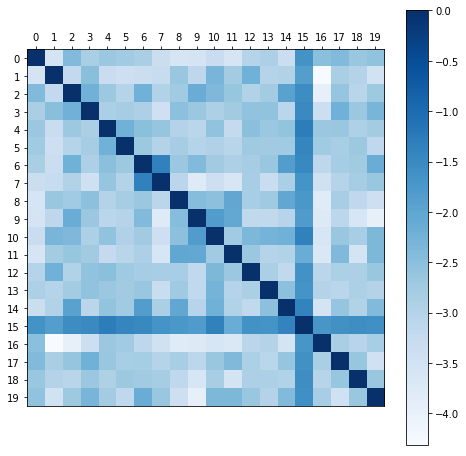

In [20]:
plot_topics(nmf_topics)

#### Examine the words that make two topics similar or different
We can also compare two topics to each other by looking at words that are common in both, or words that are common in one but not the other. Try changing topic_a and topic_b to different topic numbers.

In [21]:
topic_a = 0
topic_b = 1

describe_intersection(nmf_topics, topic_a, topic_b, tfidf_feature_names, n_words=nshow)
describe_difference(nmf_topics, topic_a, topic_b, tfidf_feature_names, n_words=nshow)
describe_difference(nmf_topics, topic_b, topic_a, tfidf_feature_names, n_words=nshow)

Words in 0 and 1: wouldn dont lol song songs weird getting feel maybe dance
Words in 0 but not in 1: like wouldn music feel girls sing dance smell movies watching
Words in 1 but not in 0: know want better let wouldn need maybe wanna dont share


### Step 5: Interpret these topics
- This part is for you to do: code can't do it for you.
- Look at the list of important words for each topic, and think about these questions.
    - What do the words have in common?
    - What could someone write that would use most of those words?
    - What does this topic seem to be about?
- Try to come up with a short, catchy name for each topic.
    - For example, if the words were "san francisco city moved living born years raised lived live", you might call it "places lived" because the topic seems to be about where people currently live (San Francisco) and where they were born / raised / moved from. 
- Try other numbers of topics.
    - If the topics seem repetitive, you might want to try looking for fewer topics.
    - If the topics seem confusing or vague, you might want to try looking for more topics (so that they can be more specific).

### Step 6: Compare the topics from LDA and NMF
We can compare the topics visually using a confusion matrix plot.
The NMF topics are along the X axis and the LDA are along the Y axis.
The NMF topics are sorted to match the closest LDA topic.

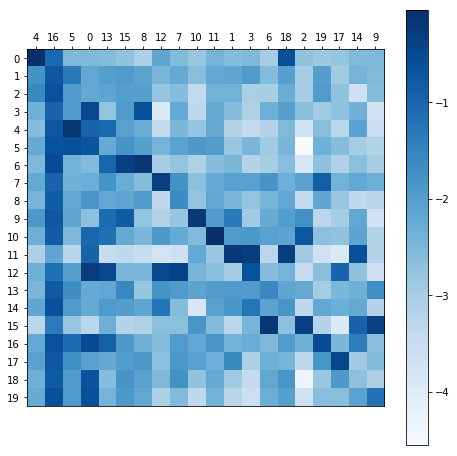

In [22]:
plot_confusion(x=nmf_topics, y=lda_topics)

By looking at the LDA and NMF topic words and the confusion matrix, consider the following questions:
- Do any of the topics seem to be the same in both models?
- Are some topics in one model but not the other?
- Do the topics you get from one of the models make more sense than the ones you get from the other?


### Step 7: Compare profiles based on their topics
For each profile, we calculate how strongly each topic appears.
This code uses the NMF model.
To use LDA instead, remove the `#` at the beginning of the second line.

In [23]:
model, text = nmf, tfidf_text
#model, text = lda, tf_text
model_doc_topic = model.transform(text)

#### Functions to visualize and compare topics

In [24]:
def visualize_profile(model_doc_topic, profile_id):
    # plot a stem diagram for a single profile
    plt.figure(figsize=(8,4))
    plt.xticks(range(model_doc_topic.shape[1]))
    plt.xlabel('Topic number')
    plt.ylabel('How well this profile matches each topic')
    plt.stem(model_doc_topic[profile_id,:])
    
def profile_histogram(model_doc_topic, topic_id):
    # get profile values within a single topic
    values = model_doc_topic[:,topic_id]
    # calculate logarithmic bins based on smallest nonzero value
    bins = np.logspace(np.log10(min([v for v in values if v > 0])),np.log10(0.4),50)
    # plot the histogram
    plt.figure(figsize=(8,4))
    plt.ylabel('Number of profiles')
    plt.xlabel('Amount of topic {} in profile'.format(topic_id))
    plt.hist(values, bins=bins)
    plt.gca().set_xscale('log')

def profile_scatter(model_doc_topic, topic_x_id, topic_y_id):
    # create a scatter plot of profiles with each axis representing one topic
    plt.figure(figsize=(8,8))
    plt.loglog(model_doc_topic[:,topic_x_id], model_doc_topic[:,topic_y_id], '.', markersize=1)
    plt.xlabel('Amount of topic {}'.format(topic_x_id))
    plt.ylabel('Amount of topic {}'.format(topic_y_id))
    
def topic_cooccurance(topics):
    m = pd.DataFrame(topics).corr()
    # create a figure and plot the similarites
    plt.figure()
    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(m, cmap='Blues')
    plt.xticks(range(20))
    plt.yticks(range(20))
    plt.title('Topic co-occurance (correlation in profile data)')
    # plot a colorbar legend
    plt.colorbar()
    
def get_profiles_from_topics(data, transformed, topic1, topic2=None):
    df = pd.DataFrame(transformed)
    df = df.sort_values(by=topic1, ascending=False)
    n = 10
    match_text = ''
    
    if topic2 is None:
        keep = df.head(n).sample(1)
        pid = keep.index.values[0]
        match_text = 'is in the top 10 profiles for topic ' + str(topic1) 
    else:
        df2 = df.sort_values(by=topic2, ascending=False)
        both = set()
        idxs = {'a': df.index.values, 'b': df2.index.values}
        seen = {'a': set(), 'b': set()}
        i = 0
        while len(both) < n:
            seen['a'].add(idxs['a'][i])
            seen['b'].add(idxs['b'][i])
            both = seen['a'].intersection(seen['b'])
            i += 1
        keep = df.loc[list(both), :].sample(1)
        pid = keep.index.values[0]        
        
        match_text = 'is the number '
        match_text += str(np.where(df.index==pid)[0][0])
        match_text += ' profile for topic '
        match_text += str(topic1)
        match_text += ' and the number '
        match_text += str(np.where(df2.index==pid)[0][0])
        match_text += ' profile for topic '
        match_text += str(topic2)
        
    text = data[pid]
    print('Profile number', pid, match_text)
    print('Here is the text:\n\n', text)

#### Plot the topic breakdown of particular profiles
Examine different profiles by changing the value of the `pid` varible.

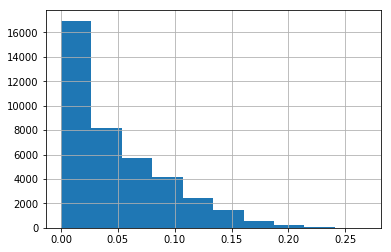

In [25]:
tmp = pd.DataFrame(model_doc_topic)
tmp.sum(axis=1).hist()

i'm picky when it comes to dating. i know what i'm looking for and
won't waste my time. or hers.


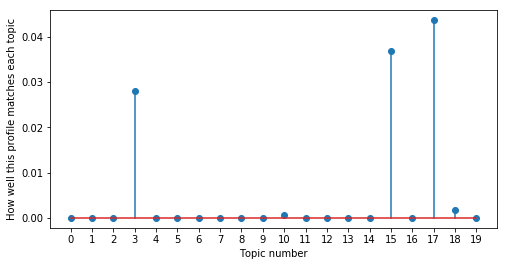

In [26]:
pid = 8

print(documents[pid])
visualize_profile(model_doc_topic, profile_id=pid)

#### Look at the text of a profile that matches a specific topic well
- This function randomly picks one of the top 10 profiles for a topic, so each time you run it you will see a different example.

In [27]:
get_profiles_from_topics(documents, model_doc_topic, topic1=3)

Profile number 31485 is in the top 10 profiles for topic 3
Here is the text:

 i'm legally handicapped, you'd never know how, though.


#### Look at the text of a profile that matches two topics well at the same time
- Note that some topics might not happen together very often. If this is the case, the examples we find of both together might not be very good.

In [28]:
get_profiles_from_topics(documents, model_doc_topic, topic1=7, topic2=11)

Profile number 33274 is the number 125 profile for topic 7 and the number 365 profile for topic 11
Here is the text:

 you've got to ask me in person.


## Step 8: Visualize all of the profiles by their topic content
We can choose a topic and plot a histogram of that topic's relevance to each of the profiles.
- Try different topics by changing `topic_id`.
- Are there any topics with multiple peaks? What does that mean?

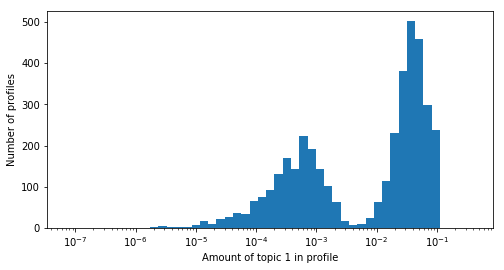

In [29]:
profile_histogram(model_doc_topic, topic_id=1)

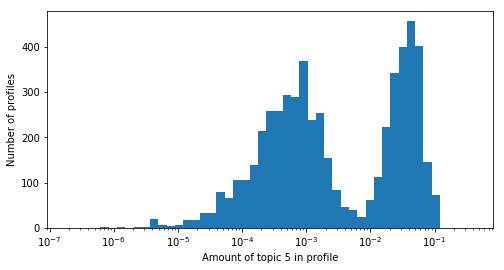

In [30]:
profile_histogram(model_doc_topic, topic_id=5)

#### See which topics tend to appear together in text
- This shows us something that looks similar to the topic similarity we saw before, but this time:
    - We don't compare topics based on which words they use
    - We do compare topics based on how often they appear in the same profile as one another
- Why is the diagonal line so dark?

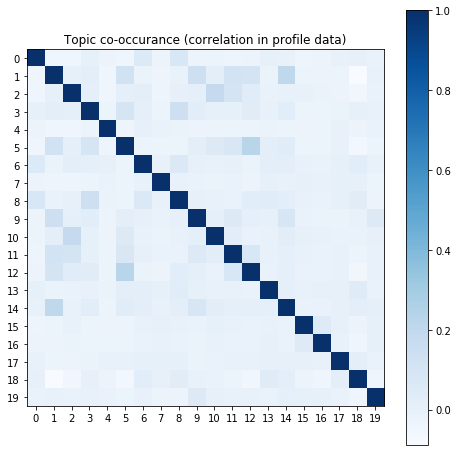

In [31]:
topic_cooccurance(model_doc_topic)

#### Analyze the relationship between two topics using a scatter plot of all profiles
- Try different topic combinations.
- Do the profiles cluster into distinct groups?
- What are the pros and cons of using a 2-D scatter plot vs the histogram above?

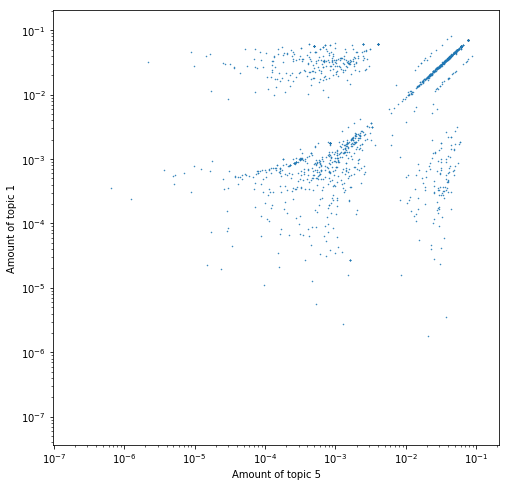

In [32]:
profile_scatter(model_doc_topic, topic_x_id=5, topic_y_id=1)

## Step 9: Who says what?
Let's examine which topics are common to which groups of people

#### Some more helper functions

In [33]:
def top_topics(data, trait, value, n_top_topics, how='mean'):
    topics = [col for col in data if col.startswith('topic_')]
    data = data[data[trait] == value]
    vals = {}
    
    for t in topics:
        if how == 'mean':
            vals[t] = data[t].mean()
        elif how == 'count':
            vals[t] = data[data[t] > 0][t].count()
    vals = pd.DataFrame.from_dict(vals, orient='index')
    vals = vals.sort_values(by=0, ascending=False).head(n_top_topics)
    
    return list(vals.index.values)

def rank_groups(data, trait, topic, how='mean'):
    groups = data[trait].value_counts().index.values
    result = {}
    
    for g in groups:
        if how == 'mean':
            result[g] = data[data[trait] == g][topic].mean()
        elif how == 'count':
            tmp = data[data[trait] == g]
            result[g] = tmp[tmp[topic] > 0][topic].count() / tmp.shape[0]
    
    r = pd.DataFrame.from_dict(result, orient='index')
    r.columns = [topic]
    r = r.sort_values(by=topic, ascending=False)
    
    return r

#### Step 1: Merge our information about topics with our information about people

In [34]:
topic_info = pd.DataFrame(model_doc_topic).add_prefix('topic_')
together = profiles.merge(topic_info, left_index=True, right_index=True)
together.head()

,age_group,age,body,alcohol_use,drug_use,edu,race_ethnicity,height_group,industry,kids,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,20,22,overweight,yes,no,HS,multiple,over_6,other,no,...,0.0,0.00000,0.0,0.0,0.000000,0.000485,0.0,0.0,0.006278,0.0
1,30,35,average,yes,yes,unknown,White,under_6,other,no,...,0.0,0.00018,0.0,0.0,0.053504,0.000000,0.0,0.0,0.000000,0.0
2,30,38,thin,yes,yes,Grad_Pro,NaN,under_6,NaN,no,...,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.006661,0.0
5,20,29,average,yes,yes,BA,White,under_6,STEM,no,...,0.0,0.00000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.023731,0.0
6,30,32,fit,yes,no,BA,multiple,under_6,NaN,no,...,0.0,0.00000,0.0,0.0,0.001461,0.000000,0.0,0.0,0.011188,0.0


#### Step 2a: See the topics that take up the most text for a given group
- This example shows top topics for different education levels.
- You can change the arguments to compare different groups

In [35]:
#show what information we have about people
together.columns.values

array(['age_group', 'age', 'body', 'alcohol_use', 'drug_use', 'edu',
       'race_ethnicity', 'height_group', 'industry', 'kids', 'orientation',
       'pets_likes', 'pets_has', 'pets_any', 'religion', 'sex', 'smoker',
       'languages', 'text', 'essay0', 'essay1', 'essay2', 'essay3',
       'essay4', 'essay5', 'essay6', 'essay7', 'essay8', 'essay9', 'clean',
       'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5',
       'topic_6', 'topic_7', 'topic_8', 'topic_9', 'topic_10', 'topic_11',
       'topic_12', 'topic_13', 'topic_14', 'topic_15', 'topic_16',
       'topic_17', 'topic_18', 'topic_19'], dtype=object)

In [36]:
#show what categories we have for education
together['edu'].value_counts()

BA          12968
Grad_Pro     5469
unknown      4693
HS           3922
<HS            88
Name: edu, dtype: int64

In [37]:
#show most popular topics for High School graduates
top_topics(data=together, trait='edu', value='HS', n_top_topics=3)

['topic_18', 'topic_0', 'topic_2']

In [38]:
#show most popular topics for people with graduate and professional degrees
top_topics(together, 'edu', 'Grad_pro', 3)

['topic_0', 'topic_1', 'topic_2']

In [39]:
# show our topics again so we know what they are
display_topics(nmf_topics, tfidf_feature_names, nshow)

Topic 0: like wouldn music feel girls sing dance smell movies watching
Topic 1: know want better let wouldn need maybe wanna dont share
Topic 2: ask answer want question shall free honest hide questions away
Topic 3: private wouldn things anymore thing admitted internet public share told
Topic 4: really bad good enjoy want secrets hard loud sure kind
Topic 5: ve got seen years times told relationship past life known
Topic 6: ll meet answer share let talk wait save probably guess
Topic 7: dating online site profile website thing actually trying internet using
Topic 8: love secretly music sex movies fall romantic true watching eat
Topic 9: tell later maybe ill ya meet date lol probably secret
Topic 10: person meet right better morning pretty open talk share internet
Topic 11: just kidding say want guess wait need share fun going
Topic 12: admit willing thing things won public internet lot publicly question
Topic 13: think sexy let question funny hmm thing hot moment cool
Topic 14: open b

#### Step 2b: See the topics that show up even a little in the most profiles for a given group
- Compare these with the ones above. How are they different? Why might that be? 

In [40]:
#show most popular topics for High School graduates
top_topics(together, 'edu', 'HS', 3, how='count')

['topic_18', 'topic_0', 'topic_7']

In [41]:
#show most popular topics for people with graduate and professional degrees
top_topics(together, 'edu', 'Grad_pro', 3, 'count')

['topic_0', 'topic_1', 'topic_18']

#### Step 3a: See the groups that have the most text about a given topic

In [42]:
rank_groups(together, trait='edu', topic='topic_18')

,topic_18
unknown,0.005274
Grad_Pro,0.005205
BA,0.005172
HS,0.005146
<HS,0.004727


#### Step 3b: See the groups where the most profiles mention a given topic
- Compare these with the results from 3a. Are they different? If so, how? Why might that be?

In [43]:
rank_groups(together, trait='edu', topic='topic_18', how='count')

,topic_18
Grad_Pro,0.751143
BA,0.745759
HS,0.738909
unknown,0.738547
<HS,0.704545


# Reflection: What we've learned
- Two statistical methods for topic modeling
    - LDA
    - NMF
- Two ways to represent text as numbers
    - TF / count vectors (counts of how often each word is used)
    - TF-IDF vectors (counts of how often each word is used, divided by the number of documents they're used in)
- How to think about and interpret the topics our models find
- How to compare and relate different topics
- Different ways to see the distribution of topics in profiles
- Which topics are most popular with social categories of people
- Which social categories of people discuss a topic most